In [15]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Add, Input, Activation, Dropout
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

import matplotlib.pyplot as plt

## Load and Clean the Metadata

We begin by loading the metadata from `train_metadata.csv`. 
This step includes:
- Converting columns to numeric types.
- Handling missing values (e.g. replacing with mean or dropping).
- Downsampling for faster processing.

In [4]:
metadata_test = pd.read_csv('test_metadata.csv')
metadata_val = pd.read_csv('val_metadata.csv')
new_metadata_train = pd.read_csv('train_metadata.csv')

In [5]:
# double checking which values should be cleaned or filled
missing_values = metadata_val['clin_size_long_diam_mm'].isna().sum()
print(f"Missing values in 'clin_size_long_diam_mm' for meta val data: {missing_values}")

missing_values = metadata_val['age_approx'].isna().sum()
print(f"Missing values in 'age_approx' for meta val data: {missing_values}")

missing_values = metadata_val['sex'].isna().sum()
print(f"Missing values in 'sex' for new meta val data: {missing_values}")

missing_values = metadata_val['diagnosis_1'].isna().sum()
print(f"Missing values in 'diagnosis_1' for meta val data: {missing_values}")

print(f'values in meta val data: {len(new_metadata_train)}')

Missing values in 'clin_size_long_diam_mm' for meta val data: 18574
Missing values in 'age_approx' for meta val data: 945
Missing values in 'sex' for new meta val data: 2760
Missing values in 'diagnosis_1' for meta val data: 0
values in meta val data: 349531


In [6]:
missing_values = new_metadata_train['clin_size_long_diam_mm'].isna().sum()
print(f"Missing values in 'clin_size_long_diam_mm' for new meta train data: {missing_values}")

missing_values = new_metadata_train['age_approx'].isna().sum()
print(f"Missing values in 'age_approx' for new meta train data: {missing_values}")

missing_values = new_metadata_train['sex'].isna().sum()
print(f"Missing values in 'sex' for new meta train data: {missing_values}")

missing_values = new_metadata_train['diagnosis_1'].isna().sum()
print(f"Missing values in 'diagnosis_1' for new meta train data: {missing_values}")

print(f'values in new meta train data: {len(new_metadata_train)}')

Missing values in 'clin_size_long_diam_mm' for new meta train data: 65517
Missing values in 'age_approx' for new meta train data: 3398
Missing values in 'sex' for new meta train data: 9608
Missing values in 'diagnosis_1' for new meta train data: 0
values in new meta train data: 349531


In [7]:
#filling in missing values for clin_size_long_diam_mm

meanTestVal = metadata_test['clin_size_long_diam_mm'].mean()
metadata_test['clin_size_long_diam_mm'] = metadata_test['clin_size_long_diam_mm'].fillna(meanTestVal)

meanTrainVal = new_metadata_train['clin_size_long_diam_mm'].mean()
new_metadata_train['clin_size_long_diam_mm'] = new_metadata_train['clin_size_long_diam_mm'].fillna(meanTrainVal)

meanValidationVal = metadata_val['clin_size_long_diam_mm'].mean()
metadata_val['clin_size_long_diam_mm'] = metadata_val['clin_size_long_diam_mm'].fillna(meanValidationVal)

meanTrainVal = new_metadata_train['clin_size_long_diam_mm'].mean()
new_metadata_train['clin_size_long_diam_mm'] = new_metadata_train['clin_size_long_diam_mm'].fillna(meanTrainVal)
new_metadata_train.head()

,age_approx,clin_size_long_diam_mm,sex,diagnosis_1
0,45.0,2.60,1.0,0.0
1,70.0,4.32,0.0,0.0
2,40.0,2.62,0.0,0.0
3,65.0,6.20,1.0,0.0
4,85.0,5.07,1.0,0.0


In [8]:
metadata_test.head()

,age_approx,clin_size_long_diam_mm,sex,diagnosis_1
0,55.0,2.88,1.0,0.0
1,50.0,2.96,1.0,0.0
2,55.0,4.97,0.0,0.0
3,50.0,3.84,0.0,0.0
4,75.0,2.82,0.0,0.0


In [9]:
# drop rows with missing values

metadata_test.dropna(subset=['age_approx', 'sex', 'diagnosis_1'], inplace=True)

new_metadata_train.dropna(subset=['age_approx', 'sex', 'diagnosis_1'], inplace=True)

metadata_val.dropna(subset=['age_approx', 'sex', 'diagnosis_1'], inplace=True)

In [10]:
missing_values = new_metadata_train['clin_size_long_diam_mm'].isna().sum()
print(f"Missing values in 'clin_size_long_diam_mm' for new meta train data: {missing_values}")

missing_values = new_metadata_train['age_approx'].isna().sum()
print(f"Missing values in 'age_approx' for new meta train data: {missing_values}")

missing_values = new_metadata_train['sex'].isna().sum()
print(f"Missing values in 'sex' for new meta train data: {missing_values}")

missing_values = new_metadata_train['diagnosis_1'].isna().sum()
print(f"Missing values in 'diagnosis_1' for new meta train data: {missing_values}")

print(f'values in new meta train data: {len(new_metadata_train)}')

Missing values in 'clin_size_long_diam_mm' for new meta train data: 0
Missing values in 'age_approx' for new meta train data: 0
Missing values in 'sex' for new meta train data: 0
Missing values in 'diagnosis_1' for new meta train data: 0
values in new meta train data: 338456


In [11]:
metadata_X_test = metadata_test.iloc[:, :-1]
metadata_Y_test = metadata_test.iloc[:, -1]
metadata_X_val = metadata_val.iloc[:, :-1]
metadata_Y_val = metadata_val.iloc[:, -1]

new_metadata_X_train = new_metadata_train.iloc[:, :-1]
new_metadata_Y_train = new_metadata_train.iloc[:, -1]

In [12]:
new_metadata_X_train.head()

,age_approx,clin_size_long_diam_mm,sex
0,45.0,2.60,1.0
1,70.0,4.32,0.0
2,40.0,2.62,0.0
3,65.0,6.20,1.0
4,85.0,5.07,1.0


In [13]:
new_metadata_Y_train.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: diagnosis_1, dtype: float64

## Define Metadata-Only Neural Network

We build a neural network using only metadata features (age, lesion diameter, and sex). The architecture includes:

- Two initial dense layers to extract feature representations.
- A **dropout** with a rate of 0.3 between the two initial layers. 
- Final dense layers for prediction.

In [64]:
numberOfColumns = 3 #age, diameter, sex
inputs = Input(shape=(numberOfColumns,))

x = Dense(64, activation="relu")(inputs)  # First Dense layer
x = Dropout(0.3)(x) 
x = Dense(64, activation="relu")(x)       # Second Dense layer

# # residual block
# residual_input = x # Save input for the residual connection

# # dense layers inside the residual block
# xRes = Dense(16, activation="relu")(x)
# xRes = Dense(16, activation="relu")(xRes)

# # ensures residual input will match same dimensions as the output of our residual block
# if residual_input.shape[-1] != xRes.shape[-1]:
#     residual_input = Dense(16)(residual_input)


# # adding the residual input to the output
# xRes = Add()([xRes, residual_input])

# # skip connection
# skip_connection = Dense(16)(inputs)

# xSkip = Add()([xRes, skip_connection])  # combine residual block output with skip connection


# # final layers
# x = Dense(16, activation="relu")(xSkip)
# x = Dense(16, activation="relu")(x)

output = Dense(1, activation="sigmoid")(x)

In [65]:
model = Model(inputs=inputs, outputs=output)

In [66]:
model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])

In [67]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

## Defining Callbacks for Training

We define two callbacks to monitor and control training:

- **EarlyStopping**: Stops training early if the validation loss does not improve after a specified number of epochs.
- **ModelCheckpoint**: Saves the best model (based on validation loss) during training.

In [68]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [69]:
es = EarlyStopping(monitor='val_accuracy',
                           patience=50,
                           restore_best_weights=True,
                           verbose=1) # early stopping



checkpoint = ModelCheckpoint('best_MLP_model.keras', monitor='val_loss', save_best_only=True)

## Compiling and Training the MLP Model

Now we build, compile, and train the CNN model defined earlier using the training and validation datasets. We use:

- **Adam** optimizer
- **Binary cross-entropy** loss function (suitable for binary classification)
- **Accuracy** as the evaluation metric

We also use the previously defined callbacks (`early_stopping` and `checkpoint`) to manage training.

In [70]:
networkHistory = model.fit(new_metadata_X_train, new_metadata_Y_train,
                    validation_data=(metadata_X_val, metadata_Y_val),
                    epochs=800,
                    batch_size=128,
                    callbacks=[es, checkpoint],
                    verbose=2)

Epoch 1/800
2645/2645 - 2s - 679us/step - accuracy: 0.9610 - loss: 0.1850 - val_accuracy: 0.9625 - val_loss: 0.1536
Epoch 2/800
2645/2645 - 1s - 469us/step - accuracy: 0.9624 - loss: 0.1533 - val_accuracy: 0.9625 - val_loss: 0.1446
Epoch 3/800
2645/2645 - 1s - 489us/step - accuracy: 0.9624 - loss: 0.1460 - val_accuracy: 0.9624 - val_loss: 0.1397
Epoch 4/800
2645/2645 - 1s - 468us/step - accuracy: 0.9624 - loss: 0.1416 - val_accuracy: 0.9625 - val_loss: 0.1363
Epoch 5/800
2645/2645 - 1s - 472us/step - accuracy: 0.9625 - loss: 0.1391 - val_accuracy: 0.9625 - val_loss: 0.1374
Epoch 6/800
2645/2645 - 1s - 470us/step - accuracy: 0.9624 - loss: 0.1368 - val_accuracy: 0.9625 - val_loss: 0.1341
Epoch 7/800
2645/2645 - 1s - 462us/step - accuracy: 0.9625 - loss: 0.1341 - val_accuracy: 0.9624 - val_loss: 0.1366
Epoch 8/800
2645/2645 - 1s - 463us/step - accuracy: 0.9624 - loss: 0.1326 - val_accuracy: 0.9625 - val_loss: 0.1372
Epoch 9/800
2645/2645 - 1s - 473us/step - accuracy: 0.9624 - loss: 0.131

## Evaluating the Trained Model on the Test Set

We define a function `evaluate_model_on_test()` that performs a thorough evaluation of the trained model on the test dataset. The function:

- Generates predictions and applies a classification threshold.
- Displays a confusion matrix.
- Plots the **ROC Curve**.

This allows us to better understand model performance beyond simple accuracy.

In [71]:
# evaluate on the validation set
test_loss, test_acc = model.evaluate(metadata_X_test, metadata_Y_test, verbose=1)

1511/1511 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - accuracy: 0.9623 - loss: 0.1378


In [72]:
num_params = model.count_params()

# final results
final_train_loss = networkHistory.history['loss'][-1]

# print the results
print(f"Number of parameters: {num_params}")
print(f"Final training loss: {final_train_loss}")
print(f"Final test loss: {test_loss}")

Number of parameters: 4481
Final training loss: 0.11585741490125656
Final test loss: 0.13644461333751678


1511/1511 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step


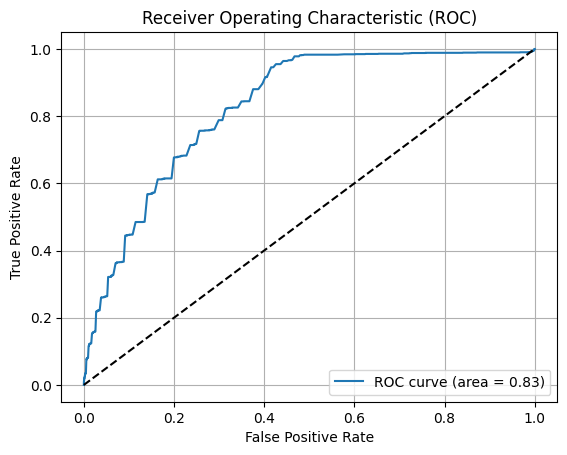

Test AUROC: 0.8286


In [73]:
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay


y_pred_probs = model.predict(metadata_X_test)  # Probabilities (needed for AUROC)
y_pred_classes = (y_pred_probs > 0.5).astype(int)  # Binary 0/1 predictions

fpr, tpr, thresholds = roc_curve(metadata_Y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Test AUROC: {roc_auc:.4f}")

In [74]:
balanced_acc = balanced_accuracy_score(metadata_Y_test, y_pred_classes)
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Balanced Accuracy: 0.5048


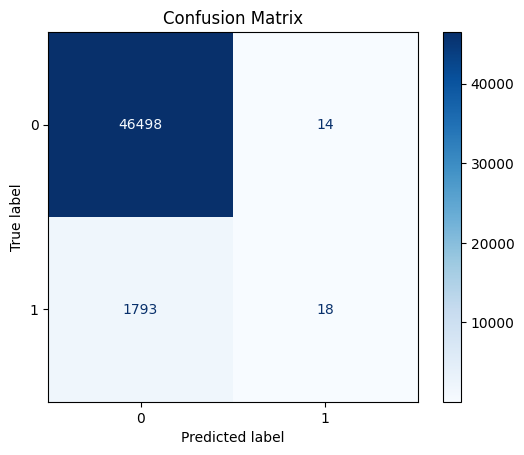

In [75]:
cm = confusion_matrix(metadata_Y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()